Este código implementa o algoritmo AutoCloud, uma abordagem baseada em aprendizado não supervisionado para a detecção de padrões e agrupamento de dados. Usando dataset com dados rotulados, primeiro teste com as 5 flags

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.graph_objects as go
from scipy.spatial import cKDTree  # Para encontrar o centróide mais próximo
from pandas.plotting import parallel_coordinates



In [2]:
class DataCloud:
	N=0 #Conta o número total de nuvens de dados criadas.
	def __init__(self,x): #É chamado quando uma nova instância de DataCloud é criada.
		self.n=1 #Inicializa o n de pontos na nuvem como 1, pois estamos adicionando o primeiro ponto x.
		self.mean=x #Inicializa a média da nuvem como o valor do primeiro ponto x. A média é o centro da nuvem.
		self.variance=0 #Inicializa a variância como 0, pois com apenas um ponto, não há dispersão.
		self.pertinency=1 #Inicializa o grau de pertinência como 1, indicando que o ponto pertence completamente à nuvem.
		DataCloud.N+=1 #Incrementa o contador de nuvens de dados criadas.
	def addDataClaud(self,x):
		self.n=2 #Define o n de pontos na nuvem como 2, assumindo que estamos adicionando um segundo ponto
		self.mean=(self.mean+x)/2 #Atualiza a média da nuvem. A nova média é a média aritmética entre a média anterior e o novo ponto x.
		self.variance=((np.linalg.norm(self.mean-x))**2) #Atualiza a variância da nuvem. A variância é calculada como o quadrado da distância entre a nova média e o novo ponto x.
	def updateDataCloud(self,n,mean,variance): #Este método atualiza os atributos da nuvem de dados com novos valores.
		self.n=n #Atualiza o número de pontos na nuvem.
		self.mean=mean #Atualiza a média da nuvem.
		self.variance=variance #Atualiza a variância da nuvem.


In [3]:
class AutoCloud:
	c= np.array([DataCloud(0)],dtype=DataCloud)
	alfa= np.array([0.0],dtype=float)
	intersection = np.zeros((1,1),dtype=int)
	listIntersection = np.zeros((1),dtype=int)
	matrixIntersection = np.zeros((1,1),dtype=int)
	relevanceList = np.zeros((1),dtype=int)
	k=1
	def __init__(self, m):
		AutoCloud.m = m
		AutoCloud.c= np.array([DataCloud(0)],dtype=DataCloud)
		AutoCloud.alfa= np.array([0.0],dtype=float)
		AutoCloud.intersection = np.zeros((1,1),dtype=int)
		AutoCloud.listIntersection = np.zeros((1),dtype=int)
		AutoCloud.relevanceList = np.zeros((1),dtype=int)
		AutoCloud.matrixIntersection = np.zeros((1,1),dtype=int)
		AutoCloud.classIndex = []
		AutoCloud.k = 1

	def mergeClouds(self):
		i=0
		while(i<len(AutoCloud.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(AutoCloud.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(AutoCloud.listIntersection[i] == 1 and AutoCloud.listIntersection[j] == 1):
					AutoCloud.matrixIntersection[i,j] = AutoCloud.matrixIntersection[i,j] + 1;
				nI = AutoCloud.c[i].n
				nJ = AutoCloud.c[j].n
				meanI = AutoCloud.c[i].mean
				meanJ = AutoCloud.c[j].mean
				varianceI = AutoCloud.c[i].variance
				varianceJ = AutoCloud.c[j].variance
				nIntersc = AutoCloud.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					print(f'na iteracao {self.k} houve fusao de clouds')
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					AutoCloud.listIntersection = np.concatenate((AutoCloud.listIntersection[0 : i], np.array([1]), AutoCloud.listIntersection[i + 1 : j],AutoCloud.listIntersection[j + 1 : np.size(AutoCloud.listIntersection)]),axis=None)
					#atualizando lista de data clouds
					AutoCloud.c = np.concatenate((AutoCloud.c[0 : i ], np.array([newCloud]), AutoCloud.c[i + 1 : j],AutoCloud.c[j + 1 : np.size(AutoCloud.c)]),axis=None)
					#update  intersection matrix
					M0 = AutoCloud.matrixIntersection
					#Remover linhas
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;
					AutoCloud.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1

	def run(self,X):
		AutoCloud.listIntersection = np.zeros((np.size(AutoCloud.c)),dtype=int)
		if AutoCloud.k==1:
			AutoCloud.c[0]=DataCloud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k==2:
			AutoCloud.c[0].addDataClaud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k>=3:
			i=0
			createCloud = True
			AutoCloud.alfa = np.zeros((np.size(AutoCloud.c)),dtype=float)
			for data in AutoCloud.c:
				n= data.n +1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				if variance == 0:
					eccentricity = 0
				else:
					eccentricity = (1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(AutoCloud.k-2)
				data.eccAn = eccentricity
				#print('tiṕicidade normalizada',norm_typicality)
				if(norm_eccentricity<=(AutoCloud.m**2 +1)/(2*n)):
					#print('dentro do limiar. tipicidade normalizada:',norm_typicality)
					data.updateDataCloud(n,mean,variance)
					AutoCloud.alfa[i] = norm_typicality
					createCloud= False
					AutoCloud.listIntersection[i] = 1
				else:
					AutoCloud.alfa[i] = 0
					AutoCloud.listIntersection[i] = 0
				i+=1
				
			if(createCloud):
				AutoCloud.c = np.append(AutoCloud.c,DataCloud(X))
				AutoCloud.listIntersection = np.insert(AutoCloud.listIntersection,i,1)
				AutoCloud.matrixIntersection = np.pad(AutoCloud.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0))
			self.mergeClouds()
			#print('AutoCloud.alfa:', AutoCloud.alfa)
			if np.sum(AutoCloud.alfa) >0:
				AutoCloud.relevanceList = AutoCloud.alfa /np.sum(AutoCloud.alfa)
			if np.sum(AutoCloud.alfa) == 0:
				AutoCloud.relevanceList = AutoCloud.alfa /np.inf
			classIndex = np.argmax(AutoCloud.relevanceList)
			AutoCloud.classIndex.append(classIndex)


		AutoCloud.k=AutoCloud.k+1


#Carregamento e Pré-processamento de Dados

In [4]:

df = pd.read_csv('dados_rotulados.csv', sep=',') #Selecionar colunas relevantes

# Selecionar colunas relevantes
f1 = df['tcp.flags.ack'].values
f2 = df['tcp.flags.fin'].values
f3 = df['tcp.flags.syn'].values
f4 = df['tcp.flags.urg'].values
f5 = df['tcp.time_delta'].values
print(f"Total de amostras no DataFrame: {df.shape[0]}")

#Criar array de dados e transpor
dados = np.array([f1,f2,f3,f4,f5]).T
print(f"Total de amostras no array 'dados': {dados.shape}")

#Definir o número de amostras a serem plotadas
j = 88000  #Altere esse valor para o número desejado de amostras
print(f"Total de amostras no array 'dados': {j}")



Total de amostras no DataFrame: 140544
Total de amostras no array 'dados': (140544, 5)
Total de amostras no array 'dados': 88000


In [5]:

# Criar objeto AutoCloud
teste = AutoCloud(1.8) #Parametro m pode ser alterado conforme demanda do dataset.'


In [6]:

# Criar dicionário para contar quantas amostras pertencem a cada cloud
contagem_clouds = {}

# Processar apenas as primeiras j amostras
for dado in dados[:j]:
    teste.run(np.array(dado))  # Executa o AutoCloud para cada amostra
    cloud_index = teste.classIndex[-1]  # Obtém o índice da cloud associada à amostra atual
    
    # Incrementar contador para essa cloud
    if cloud_index in contagem_clouds:
        contagem_clouds[cloud_index] += 1
    else:
        contagem_clouds[cloud_index] = 1

print('--------------------------------')

# Exibir informações das clouds e o número de amostras em cada uma
for k, cloud in enumerate(teste.c, start=0):
    num_amostras = contagem_clouds.get(k, 0)  # Pega a contagem ou 0 se a cloud não tiver amostras
    print(f'Cloud número {k+1}')
    print(f'  - n: {cloud.n}') #n,número total de amostras na cloud.
    print(f'  - Média: {cloud.mean}') #Média da cloud
    print(f'  - Variância: {cloud.variance}') #Variância da cloud.
    print(f'  - Amostras associadas: {num_amostras}') #Quantidade de amostras associadas à cloud durante o processamento.
    print('+++++++++++++++++++++++++++++++')


na iteracao 10 houve fusao de clouds
na iteracao 19 houve fusao de clouds
na iteracao 30 houve fusao de clouds
na iteracao 63 houve fusao de clouds
na iteracao 72 houve fusao de clouds
na iteracao 84 houve fusao de clouds
na iteracao 131 houve fusao de clouds
na iteracao 137 houve fusao de clouds
na iteracao 173 houve fusao de clouds
na iteracao 487 houve fusao de clouds
na iteracao 534 houve fusao de clouds
na iteracao 593 houve fusao de clouds
na iteracao 801 houve fusao de clouds
na iteracao 814 houve fusao de clouds
na iteracao 892 houve fusao de clouds
na iteracao 943 houve fusao de clouds
na iteracao 965 houve fusao de clouds
na iteracao 981 houve fusao de clouds
na iteracao 1023 houve fusao de clouds
na iteracao 1054 houve fusao de clouds
na iteracao 1076 houve fusao de clouds
na iteracao 1082 houve fusao de clouds
na iteracao 1098 houve fusao de clouds
na iteracao 1112 houve fusao de clouds
na iteracao 1117 houve fusao de clouds
na iteracao 1129 houve fusao de clouds
na iteraca

In [7]:
'''
# Criar figura e eixos 3D para ver centroides e clouds
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
j=140000 #Define a quantidade de amostras serão usadas
# Plotar os pontos

for cloud in teste.c:
    m = cloud.mean
    ax.scatter(m[0], m[1], m[2],  marker='x', s=150, label='Centroide')
ax.scatter(f1[0:j], f2[0:j], f3[0:j], c='red', marker='+', s=40, label='Amostras')


# Rótulos dos eixos
ax.set_xlabel('f1 (tcp.flags.ack)')
ax.set_ylabel('f2 (tcp.flags.fin)')
ax.set_zlabel('f3 (tcp.flags.syn)')

# Título e legenda
ax.set_title(f'Visualização das Nuvens do AutoCloud (Primeiras {j} Amostras)')
ax.legend(loc='upper right')

plt.show()'
'''

"\n# Criar figura e eixos 3D para ver centroides e clouds\nfig = plt.figure(figsize=(5, 5))\nax = fig.add_subplot(111, projection='3d')\nj=140000 #Define a quantidade de amostras serão usadas\n# Plotar os pontos\n\nfor cloud in teste.c:\n    m = cloud.mean\n    ax.scatter(m[0], m[1], m[2],  marker='x', s=150, label='Centroide')\nax.scatter(f1[0:j], f2[0:j], f3[0:j], c='red', marker='+', s=40, label='Amostras')\n\n\n# Rótulos dos eixos\nax.set_xlabel('f1 (tcp.flags.ack)')\nax.set_ylabel('f2 (tcp.flags.fin)')\nax.set_zlabel('f3 (tcp.flags.syn)')\n\n# Título e legenda\nax.set_title(f'Visualização das Nuvens do AutoCloud (Primeiras {j} Amostras)')\nax.legend(loc='upper right')\n\nplt.show()'\n"

Plot dos graficos com centroides e amostras das mesmas cores

Forma dos centroides: (4, 3)
Forma das amostras: (88000, 3)


/tmp/ipykernel_11013/1746323943.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



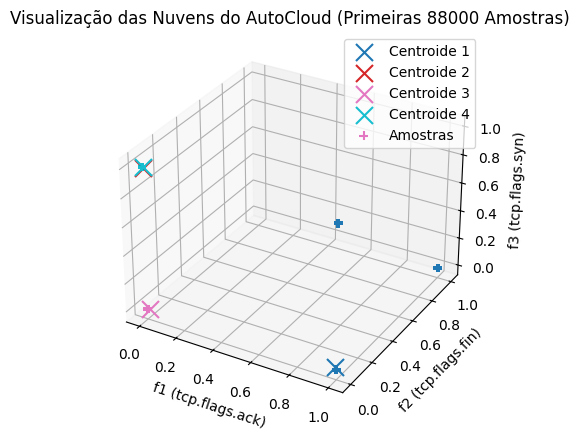

In [8]:

# Criar figura e eixos 3D
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

j = 88000  # Quantidade de amostras usadas

# Gerar cores únicas para cada centróide
num_centroides = len(teste.c)
cores_centroides = plt.cm.get_cmap("tab10", num_centroides)  # Escolher um mapa de cores

# Criar um array para armazenar as cores dos centroides
centroides = np.array([cloud.mean[:3] for cloud in teste.c])  # Pegar apenas as 3 primeiras dimensões
cores = [cores_centroides(i) for i in range(num_centroides)]

# Criar KDTree para encontrar o centróide mais próximo de cada amostra
tree = cKDTree(centroides)
amostras = np.column_stack((f1[:j], f2[:j], f3[:j]))  # Criar matriz com as 3 primeiras features
distancias, indices = tree.query(amostras)  # Encontra o centróide mais próximo
print("Forma dos centroides:", centroides.shape)  # Deve ser (N, 2) se forem bidimensionais
print("Forma das amostras:", amostras.shape)  # Deve ter o mesmo número de colunas que os centroides


# Plotar os centroides
for i, cloud in enumerate(teste.c):
    m = cloud.mean[:3]  # Usar apenas as 3 primeiras dimensões
    ax.scatter(m[0], m[1], m[2], marker='x', s=150, color=cores[i], label=f'Centroide {i+1}')

# Plotar as amostras com cores correspondentes aos centroides mais próximos
ax.scatter(f1[:j], f2[:j], f3[:j], c=[cores[i] for i in indices], marker='+', s=40, label='Amostras')

# Rótulos dos eixos
ax.set_xlabel('f1 (tcp.flags.ack)')
ax.set_ylabel('f2 (tcp.flags.fin)')
ax.set_zlabel('f3 (tcp.flags.syn)')

# Título e legenda
ax.set_title(f'Visualização das Nuvens do AutoCloud (Primeiras {j} Amostras)')
ax.legend(loc='upper right')

plt.show()

#So usar quando selecionar as colunas f4 e f5 no dataset.

In [9]:
'''
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree

# Criar figura e eixos 2D
fig, ax = plt.subplots(figsize=(6, 6))  # Criar um gráfico 2D

j = 88000  # Quantidade de amostras usadas

# Gerar cores únicas para cada centróide
num_centroides = len(teste.c)
cores_centroides = plt.cm.get_cmap("tab10", num_centroides)  # Escolher um mapa de cores

# Criar um array para armazenar as cores dos centroides
centroides = np.array([cloud.mean[:2] for cloud in teste.c])  # Pegar apenas as 2 primeiras dimensões
cores = np.array([cores_centroides(i) for i in range(num_centroides)])

# Criar KDTree para encontrar o centróide mais próximo de cada amostra
tree = cKDTree(centroides)
amostras = np.column_stack((f4[:j], f5[:j]))  # Criar matriz com as 2 primeiras features
distancias, indices = tree.query(amostras)  # Encontra o centróide mais próximo

print("Forma dos centroides:", centroides.shape)  # Deve ser (N, 2)
print("Forma das amostras:", amostras.shape)  # Deve ser (j, 2)

# Plotar os centroides
for i, cloud in enumerate(teste.c):
    m = cloud.mean[:2]  # Usar apenas as 2 primeiras dimensões
    ax.scatter(m[0], m[1], marker='x', s=150, color=cores[i], label=f'Centroide {i+1}')

# Definir cores das amostras com base no cluster mais próximo
cores_amostras = np.array([cores[i] for i in indices])
ax.scatter(f4[:j], f5[:j], color=cores_amostras, marker='+', s=40, label='Amostras')

# Rótulos dos eixos
ax.set_xlabel('f4 (tcp.flags.urg)')
ax.set_ylabel('f5 (tcp.time_delta)')

# Título e legenda
ax.set_title(f'Visualização das Nuvens do AutoCloud (Primeiras {j} Amostras)')
ax.legend(loc='upper right')

plt.show()

'''

'\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy.spatial import cKDTree\n\n# Criar figura e eixos 2D\nfig, ax = plt.subplots(figsize=(6, 6))  # Criar um gráfico 2D\n\nj = 88000  # Quantidade de amostras usadas\n\n# Gerar cores únicas para cada centróide\nnum_centroides = len(teste.c)\ncores_centroides = plt.cm.get_cmap("tab10", num_centroides)  # Escolher um mapa de cores\n\n# Criar um array para armazenar as cores dos centroides\ncentroides = np.array([cloud.mean[:2] for cloud in teste.c])  # Pegar apenas as 2 primeiras dimensões\ncores = np.array([cores_centroides(i) for i in range(num_centroides)])\n\n# Criar KDTree para encontrar o centróide mais próximo de cada amostra\ntree = cKDTree(centroides)\namostras = np.column_stack((f4[:j], f5[:j]))  # Criar matriz com as 2 primeiras features\ndistancias, indices = tree.query(amostras)  # Encontra o centróide mais próximo\n\nprint("Forma dos centroides:", centroides.shape)  # Deve ser (N, 2)\nprint("Forma das amostras:",

 #Pairplot com Seaborn

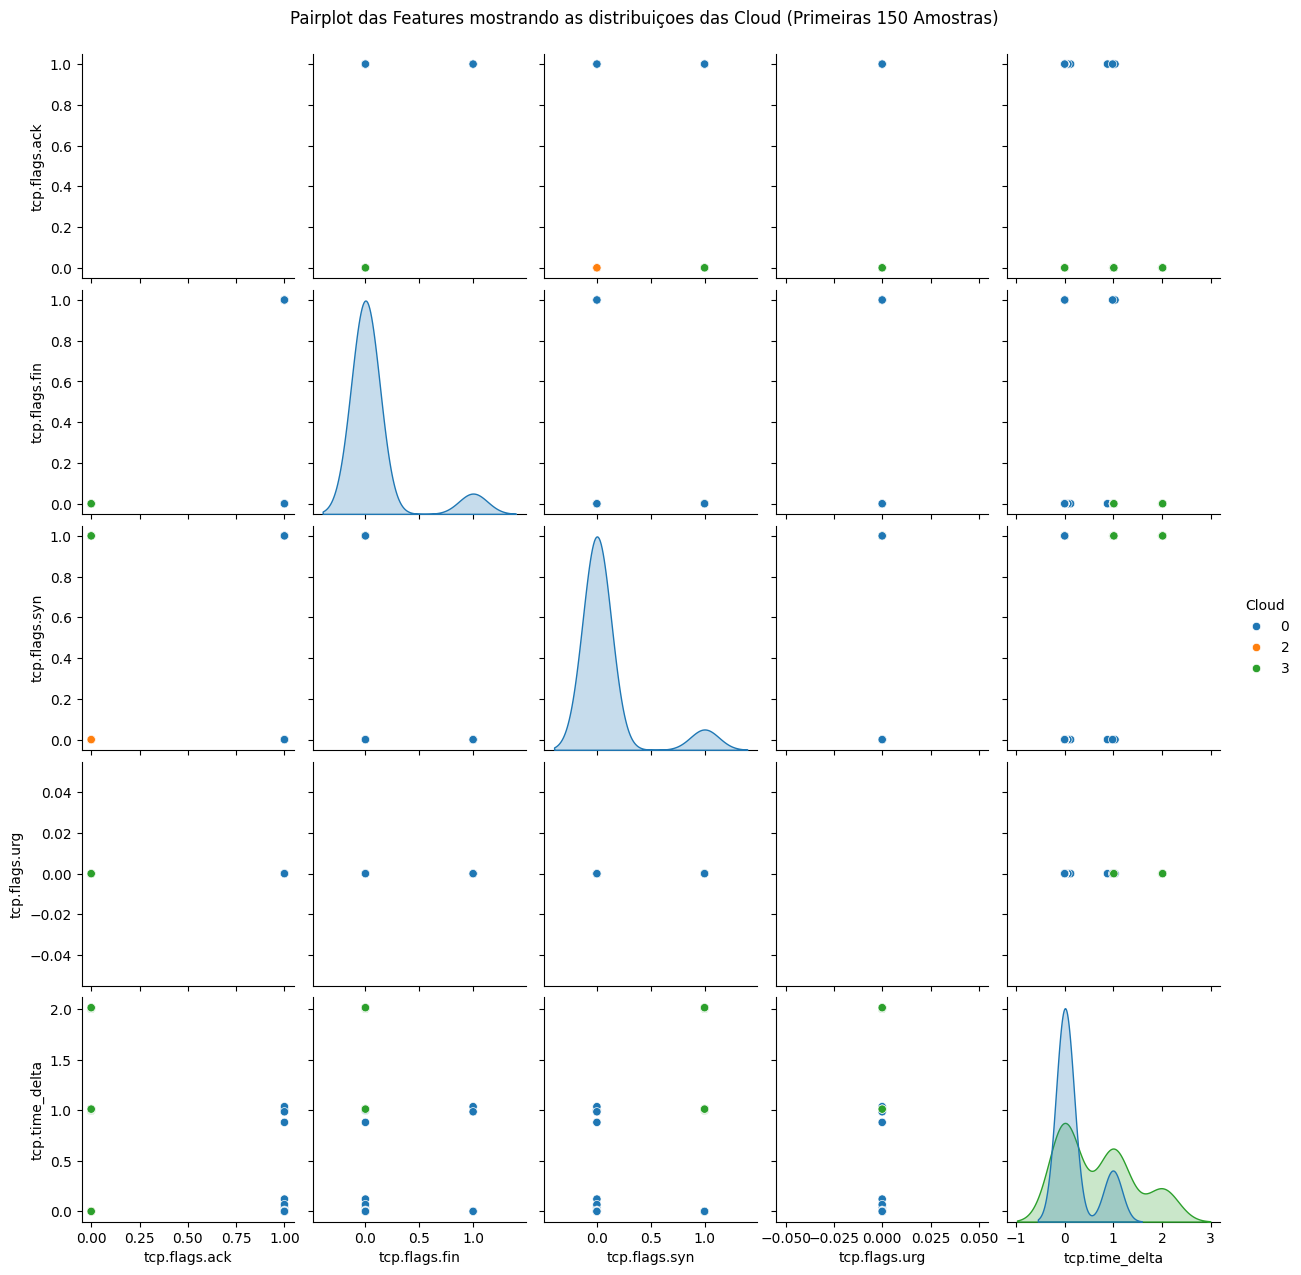

In [10]:
# Definir o número de amostras a serem plotadas
j = 150  # Altere esse valor para o número desejado de amostras

# Criar um DataFrame com as features e os clusters
df_features = pd.DataFrame({
    'tcp.flags.ack': f1[:j],
    'tcp.flags.fin': f2[:j],
    'tcp.flags.syn': f3[:j],
    'tcp.flags.urg': f4[:j],
    'tcp.time_delta': f5[:j],
    'Cloud': indices[:j]  # Usando os índices dos clusters mais próximos
})

# Plotar pairplot
sns.pairplot(df_features, hue='Cloud', palette='tab10', diag_kind='kde')
plt.suptitle(f'Pairplot das Features mostrando as distribuiçoes das Cloud (Primeiras {j} Amostras)', y=1.02)
plt.show()


